# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# commented out the imports which are not required for this assignment 

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import confusion_matrix
# from sklearn import metrics
# from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Reading Data

In [ ]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition)    # this line is redundant  
filtered_data['Score'] = actualScore.map(partition)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [ ]:
# this will help to detect duplicate values in the database based on the columns UserId, ProductId, ProfileName,
# Time, Score and Text
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [ ]:
# print(pd.read_sql_query("select UserId, ProductId, ProfileName from Reviews where UserId=='AZY10LLTJ71NX'", con))

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [ ]:
display['COUNT(*)'].sum()

393063

 Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# Lets focus on the issue rather than hard-coding id values
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator > HelpfulnessDenominator
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [ ]:
# Only taking the values having Helpfulness denominator greater than numerator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

sent_10000 = final['Text'].values[10000]
print(sent_10000)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.
Green 

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

# trying a different regex for sent_10000
sent_10000 = re.sub(r"https?:\/\/[^\s]+", "", sent_10000)
# print(sent_0)
# changing the print statement since others dont have links in their text
print(sent_10000)

Green chili sauces tend to be milder than their red companions, and this "Castillo Salsa Habanera - Green" is no exception.  It has a nice, tiny little kick to it, but it is mild enough that I could just pour it straight into my mouth.<br /><br />So, unless you don't have much tolerance for heat, you are buying this for the flavor, not the spice. And this does have a nice flavor.  It is a good blend of habanera, garlic, and some other spices, without being too vinegary or overpowering.  We had some fajitas for breakfast this morning, and this Castillo Salsa was poured quite liberally over them.  Delicious.<br /><br />It isn't quite as good as my favorite green salsa,<a href=" Jalapeno Death Sauce with Tequila</a> , but a bottle of this Castillo sauce can usually be found in my kitchen.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

# Adding our sent_10000
soup = BeautifulSoup(sent_10000, 'lxml')
text = soup.get_text()
print(text)
# we can see that the tags are removed from the text

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.
Green 

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [ ]:
# lets search the string already present before in the notebook
# print(final[final['Text'].str.contains("but these reviews do nobody any good beyond reminding")]['Text'])
sent_291694 = final['Text'][291694]
sent_291694 = re.sub(r"https?:\/\/[^\s]+", "", sent_291694)
soup = BeautifulSoup(sent_291694, 'lxml')
sent_291694 = soup.get_text()
sent_291694 = decontracted(sent_291694)
print(sent_291694)
print("="*50)
print(final['Text'][291694])
# don't like becomes do not like etc, etc

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh yeah, chocolate chip cook

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()     
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [ ]:
# Testing
ttext = "hello I @m Prince. 2 I like M-L."
print(re.findall('[^A-Za-z0-9]+', ttext))

[' ', ' @', ' ', '. ', ' ', ' ', ' ', '-', '.']


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []    # Storing score for later
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)   # adding 0-9 in the regex
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 348260/348260 [02:00<00:00, 2887.08it/s]


In [ ]:
print(len(preprocessed_reviews))
print(len(review_score))
print(review_score[:5])

348260
348260
[1, 1, 0, 1, 1]


In [ ]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [ ]:
# just trying to find the review which was there in the notebook before

preprocessed_reviews.index([stri for stri in preprocessed_reviews if 'obviously no idea ordering wants crispy cookies hey sorry' in stri][0])

60200

In [ ]:
preprocessed_reviews[60200]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [ ]:
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

  6%|▌         | 21651/348260 [00:05<01:16, 4278.62it/s]/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 27%|██▋       | 94375/348260 [00:25<01:21, 3127.40it/s]/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 60%|█████▉    | 207387/348260 [00:52<00:33, 4214.34it/s]/home/prince/anaconda3/envs/mainEnv/lib/python3.6/site-packages/bs4/__init__.p

In [ ]:
preprocessed_summary[60200]

'reviewing mistakes cookies'

In [ ]:
# deleting to free system memory
del preprocessed_summary

Featurization

Data selection

In [ ]:
# Lets reduce the size of pre-processed reviews to 5K considering the system RAM

# len(preprocessed_reviews) - 348260

choice = np.arange(len(preprocessed_reviews))
np.random.shuffle(choice)
# print(len([preprocessed_reviews[i] for i in choice[:5]]))
preprocessed_reviews = [preprocessed_reviews[i] for i in choice[:5000]]
review_score = [review_score[i] for i in choice[:5000]]
print(len(preprocessed_reviews))
print(len(review_score))

5000
5000


In [ ]:
final.head()

Id   ProductId          UserId                     ProfileName  \
138702  150520  0006641040   ADBFSA9KTQANE  James L. Hammock "Pucks Buddy"   
138707  150525  0006641040  A2QID6VCFTY51R                            Rick   
138708  150526  0006641040  A3E9QZFE9KXH8J                     R. Mitchell   
138692  150510  0006641040   AM1MNZMYMS7D8            Dr. Joshua  Grossman   
138689  150507  0006641040  A1S4A3IQ2MU7V4           sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138702                     0                       0      1  1256688000   
138707                     1                       2      1  1025481600   
138708                    11                      18      0  1129507200   
138692                     0                       0      1  1348358400   
138689                     1                       1      1  1191456000   

                                                  Summary  \
138702                                         Great Gift   
138707  In December it will be, my snowman's anniversa...   
138708                             awesome book poor size   
138692                             Professional Mentoring   
138689                      chicken soup with rice months   

                                                     Text  
138702  This book was purchased as a birthday gift for...  
138707  My daughter loves all the "Really Rosie" books...  
138708  This is one of the best children's books ever ...  
138692  TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...  
138689  This is a fun way for children to learn their ...

BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer(max_features=5000) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[40:50])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['adding', 'addition', 'additional', 'additive', 'additives', 'address', 'adds', 'adjust', 'admit', 'admittedly']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 5000)
the number of unique words  5000


Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 3258)
the number of unique words including both unigrams and bigrams  3258


TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[40:50])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['advertised', 'advice', 'afford', 'affordable', 'afraid', 'afternoon', 'aftertaste', 'agave', 'age', 'ages']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 3258)
the number of unique words including both unigrams and bigrams  3258


Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
len(list_of_sentance)

5000

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=5)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('smells', 0.9954912662506104), ('enjoy', 0.9953700304031372), ('mild', 0.9951561689376831), ('aroma', 0.9948822259902954), ('wonderful', 0.9947897791862488), ('love', 0.9947064518928528), ('bodied', 0.9946591854095459), ('texture', 0.9945013523101807), ('mint', 0.9944159388542175), ('light', 0.9944018125534058)]
[('husband', 0.9996052384376526), ('must', 0.9995363354682922), ('varieties', 0.9995101690292358), ('recipes', 0.999482274055481), ('experience', 0.9994533061981201), ('idea', 0.9994456768035889), ('frozen', 0.9994245767593384), ('pop', 0.9994211792945862), ('earth', 0.9994187355041504), ('simple', 0.9993880987167358)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4213
sample words  ['strong', 'blends', 'finally', 'found', 'coffee', 'like', 'nice', 'aroma', 'taste', 'not', 'leave', 'head', 'bad', 'many', 'candy', 'bars', 'wonderful', 'go', 'new', 'put', 'minute', 'border', 'direction', 'buy', 'flavor', 'light', 'wish', 'would', 'market', 'bar', 'us', 'oh', 'chips', 'greasy', 'satisfying', 'crunch', 'although', 'actual', 'potato', 'one', 'grocery', 'store', 'area', 'carries', 'frequently', 'stock', 'even', 'bag', 'worse', 'lucky']


Converting text into vectors using wAvg W2V, TFIDF-W2V

Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:05<00:00, 989.63it/s] 

5000
50


TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
list(dictionary.items())[100:150]

[('activities', 8.418780882750795),
 ('activity', 7.320168594082684),
 ('actor', 8.824245990858959),
 ('actors', 8.824245990858959),
 ('acts', 7.907955258984804),
 ('actual', 5.756193055725341),
 ('actually', 4.204187192377116),
 ('acumen', 8.824245990858959),
 ('acv', 8.824245990858959),
 ('ad', 8.824245990858959),
 ('adagio', 8.824245990858959),
 ('adam', 8.824245990858959),
 ('adapt', 8.418780882750795),
 ('adaptation', 8.418780882750795),
 ('adapter', 8.824245990858959),
 ('add', 3.813610696762703),
 ('added', 4.346909176380752),
 ('addiciton', 8.824245990858959),
 ('addict', 7.320168594082684),
 ('addicted', 6.221556305414575),
 ('addicting', 6.952443813957367),
 ('addiction', 7.437951629739068),
 ('addictive', 6.381898955489754),
 ('addicts', 8.824245990858959),
 ('adding', 5.406519307245593),
 ('addition', 5.566149452837476),
 ('additional', 5.8285137173049675),
 ('additionally', 8.131098810299013),
 ('additions', 8.418780882750795),
 ('additive', 7.571483022363591),
 ('additive

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:29<00:00, 168.30it/s]


In [ ]:
# deleting the word2Vec model to free RAM

del w2v_model

Applying TSNE

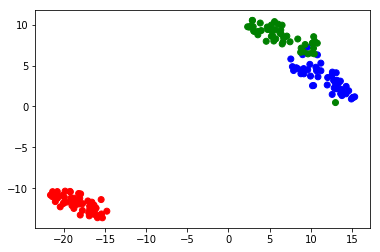

In [ ]:
# https://github.com/pavlin-policar/fastTSNE
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris['data'], iris['target']

# print(len(x), len(y))

tsne = TSNE( n_components=2, perplexity=30, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=750)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

Applying TNSE on Text BOW vectors

2-D representation of BOW vectors using TSNE


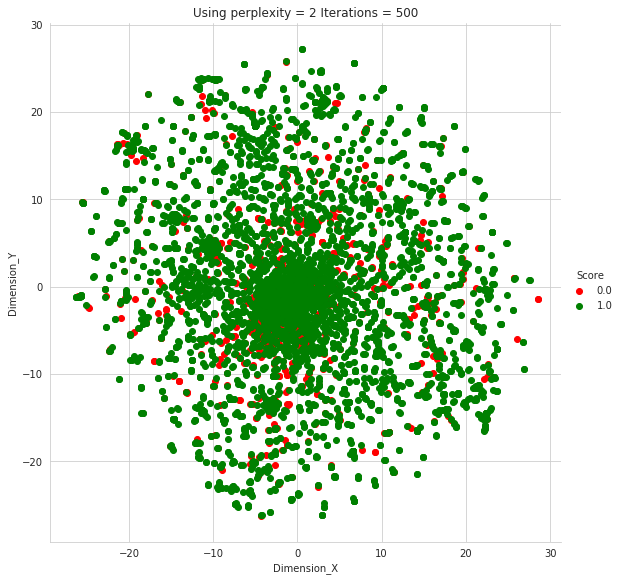

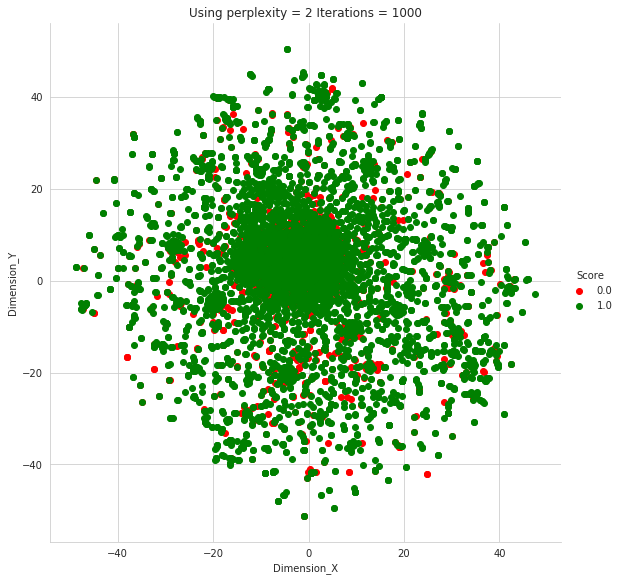

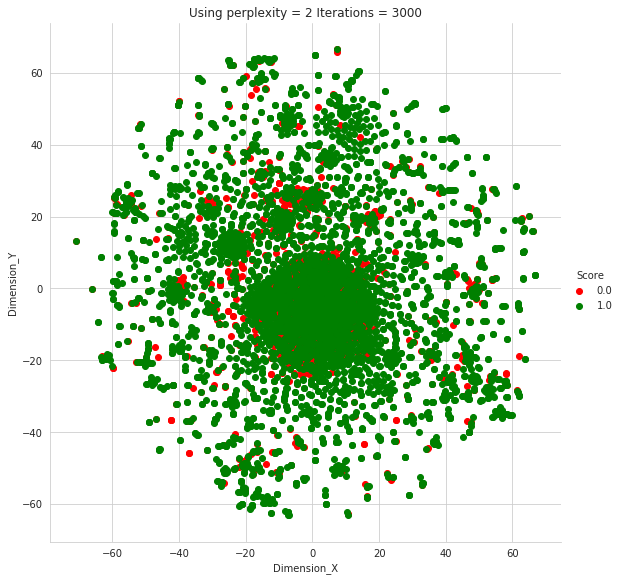

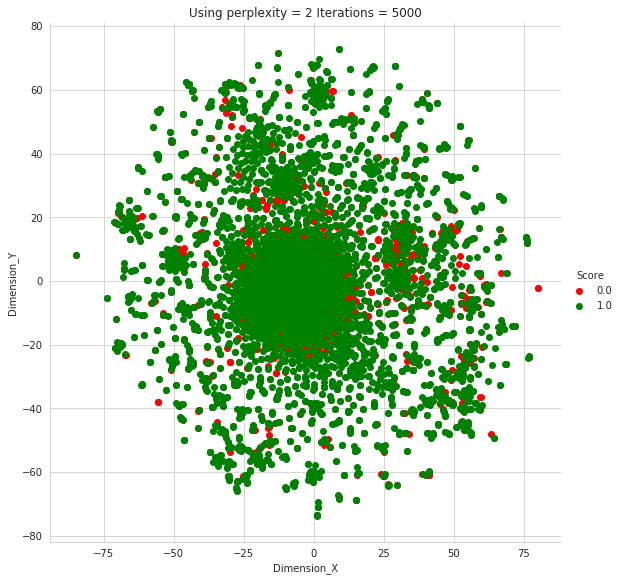

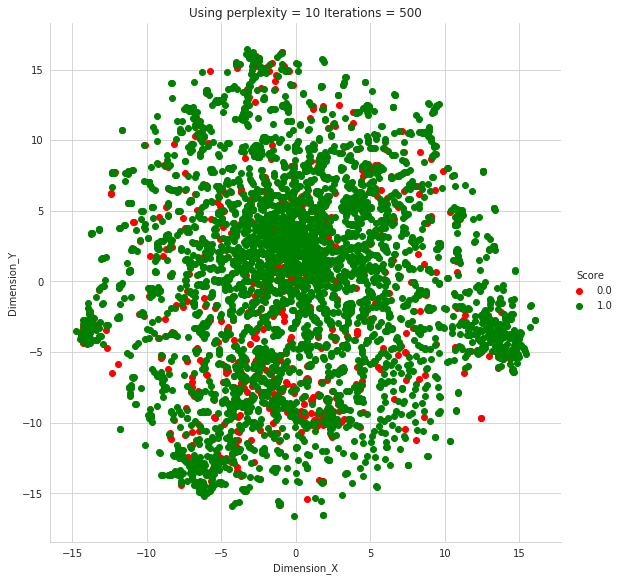

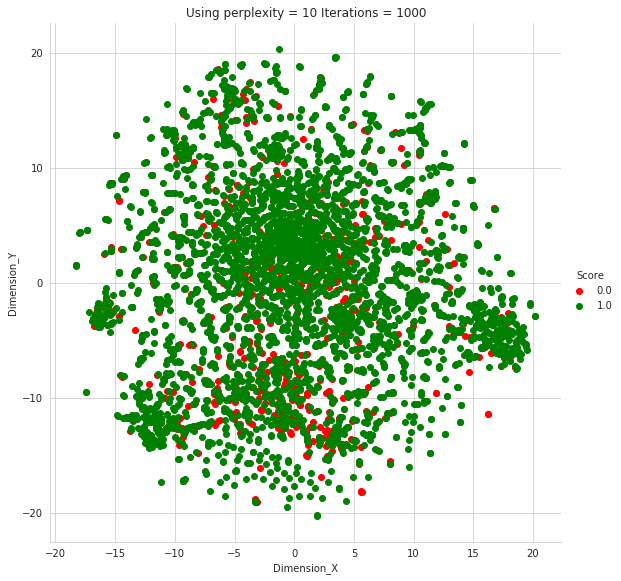

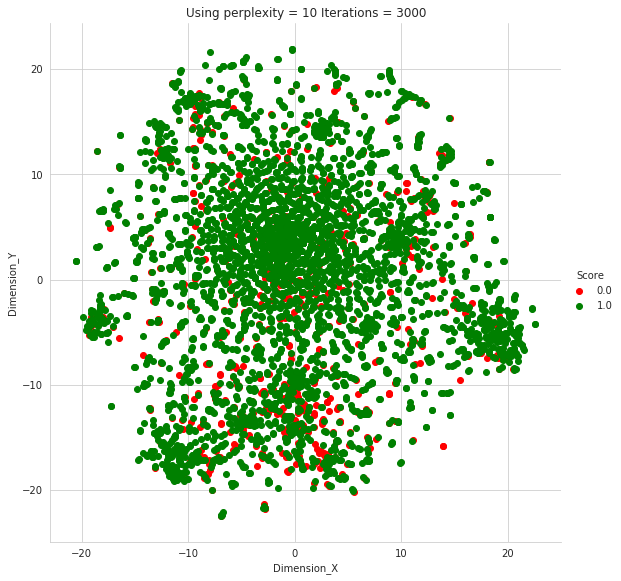

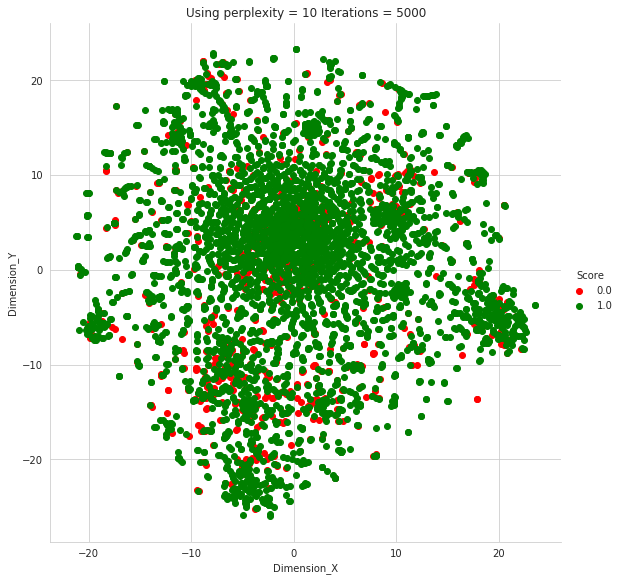

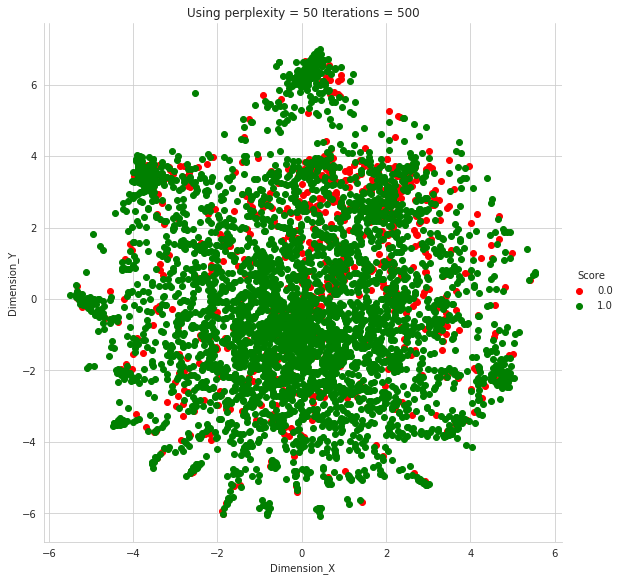

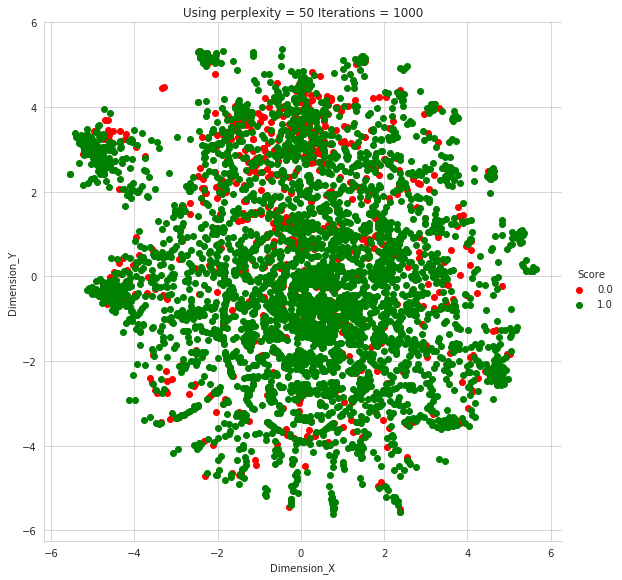

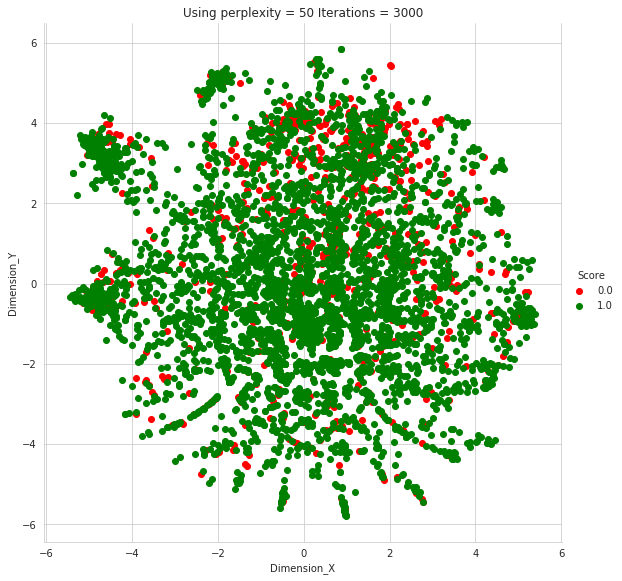

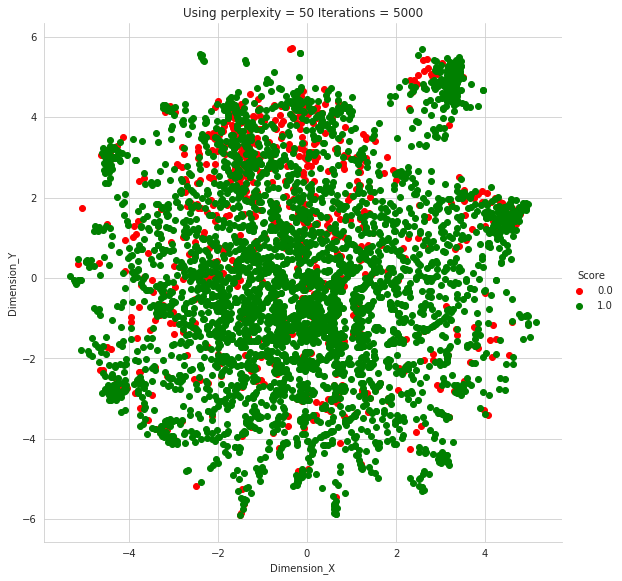

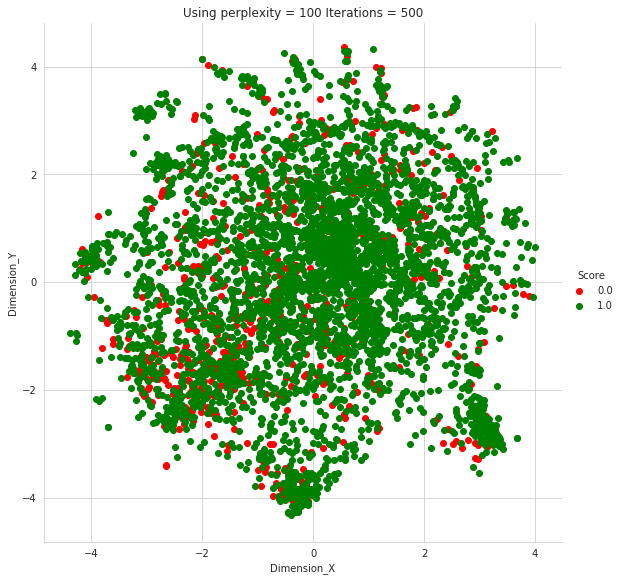

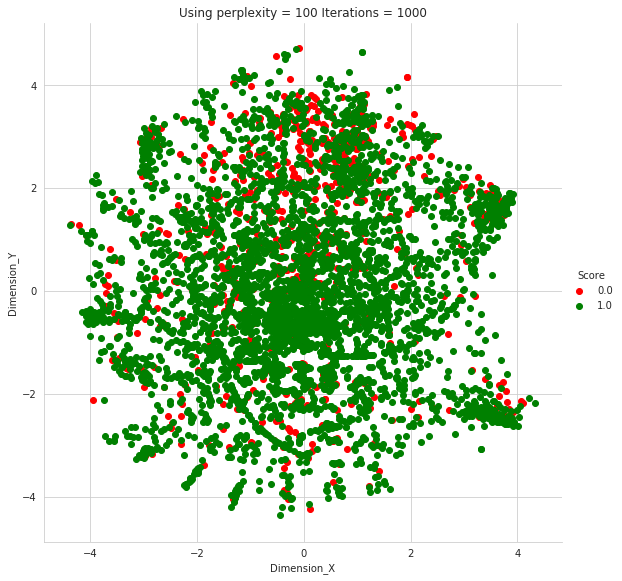

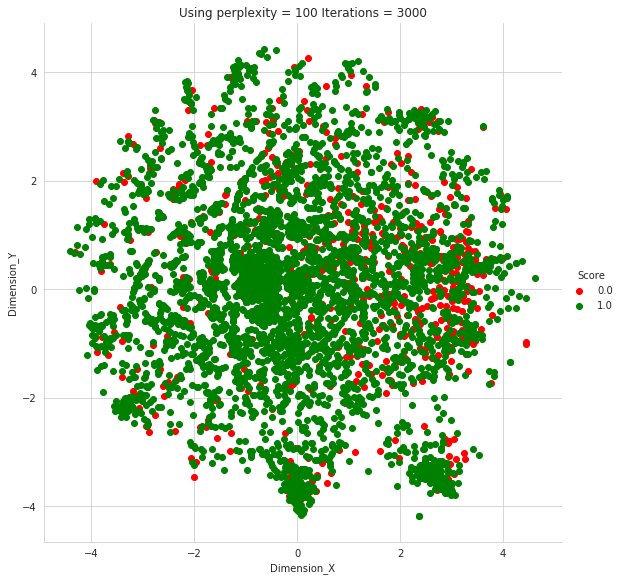

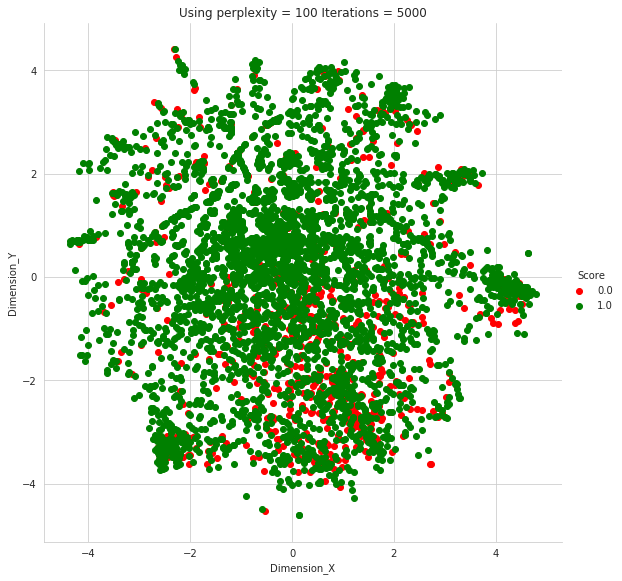

In [ ]:


    
# Using multiCore tSNE as openTSNE is causing system to crash
# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of BOW vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = final_counts.A, review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=5).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 


Applying TNSE on Text TFIDF vectors

2-D representation of Tf-IDF vectors using TSNE


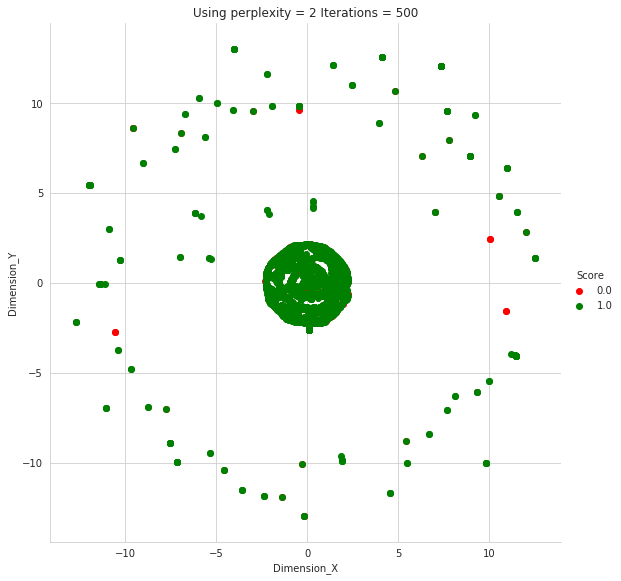

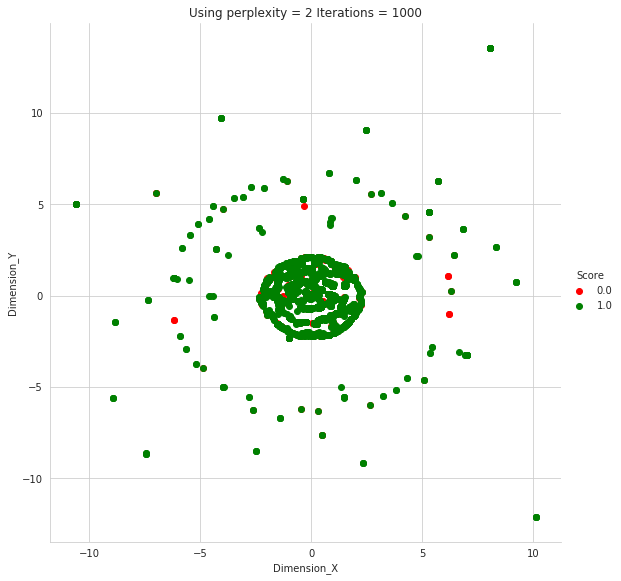

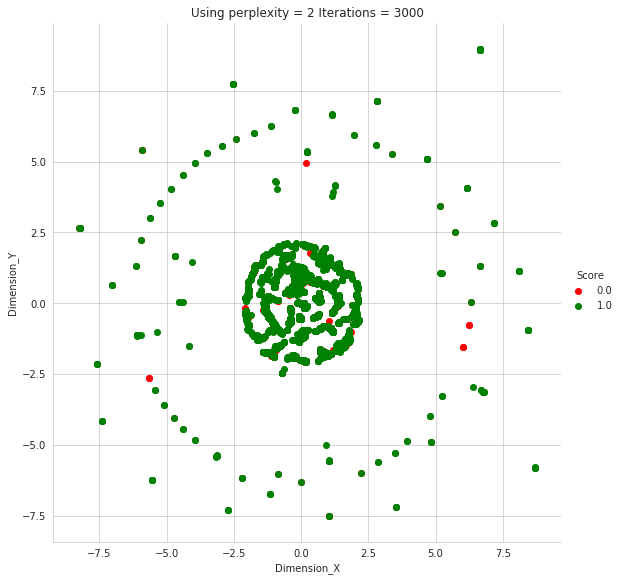

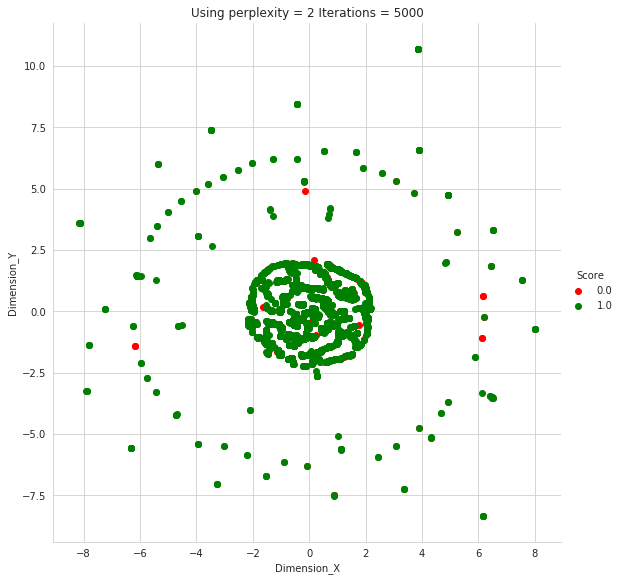

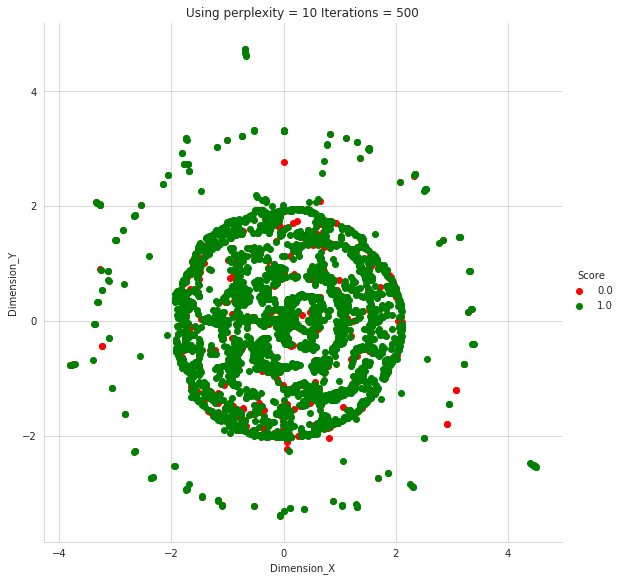

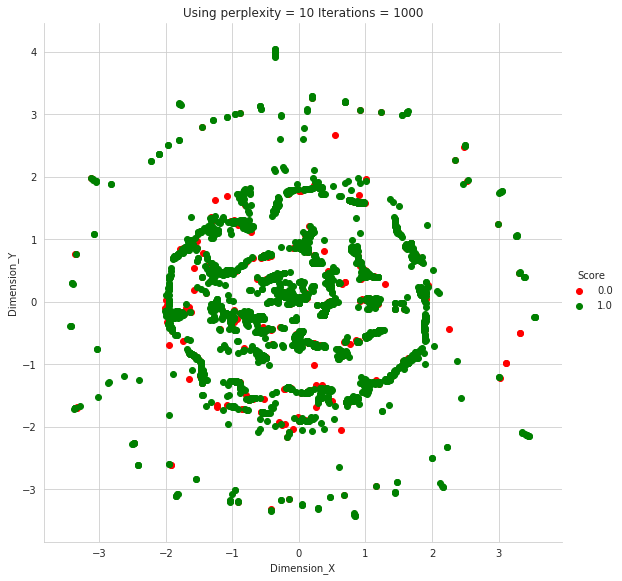

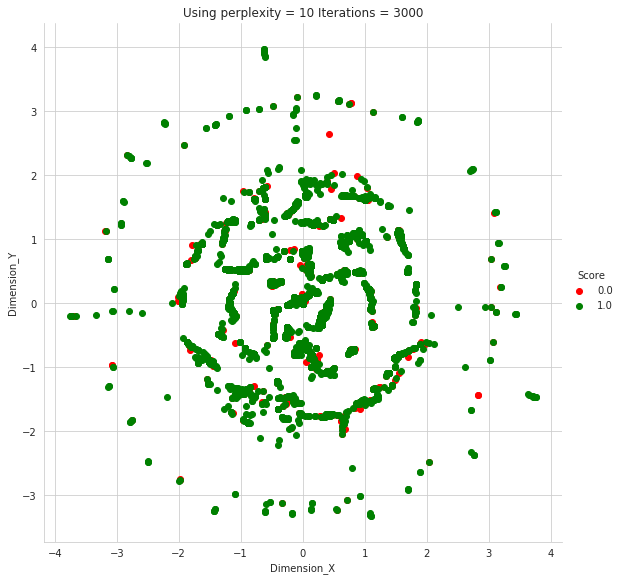

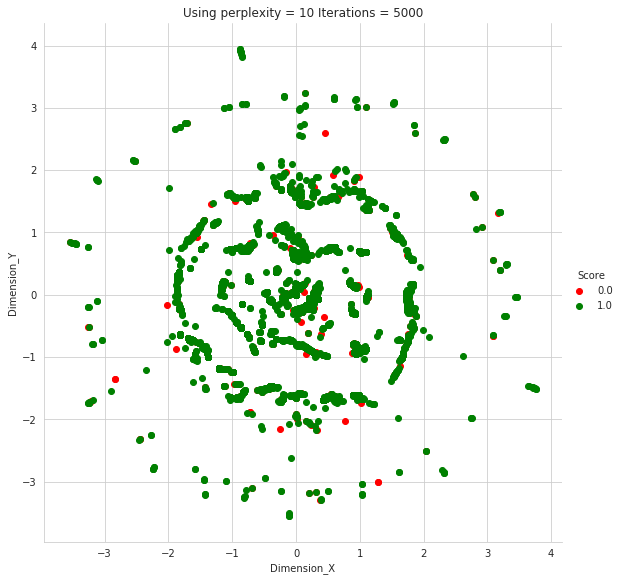

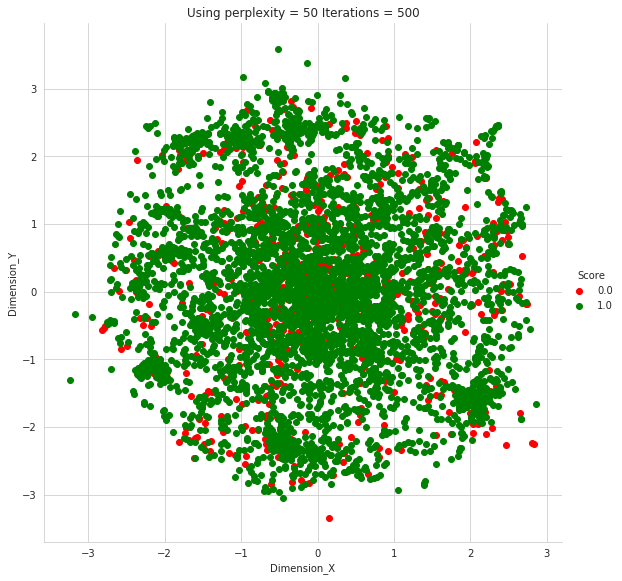

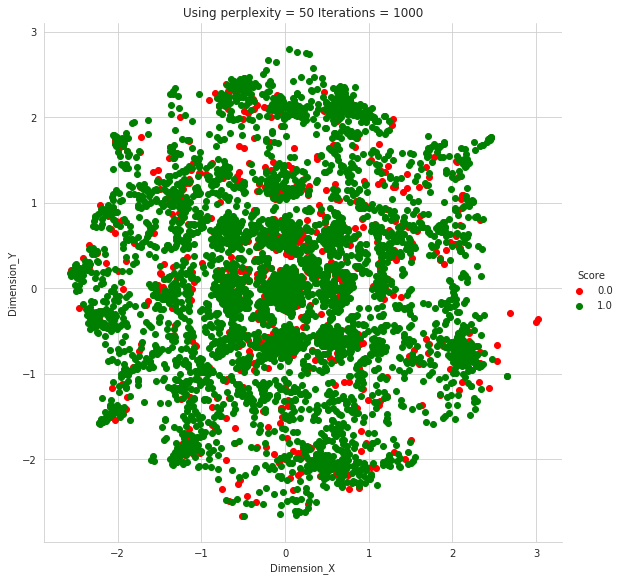

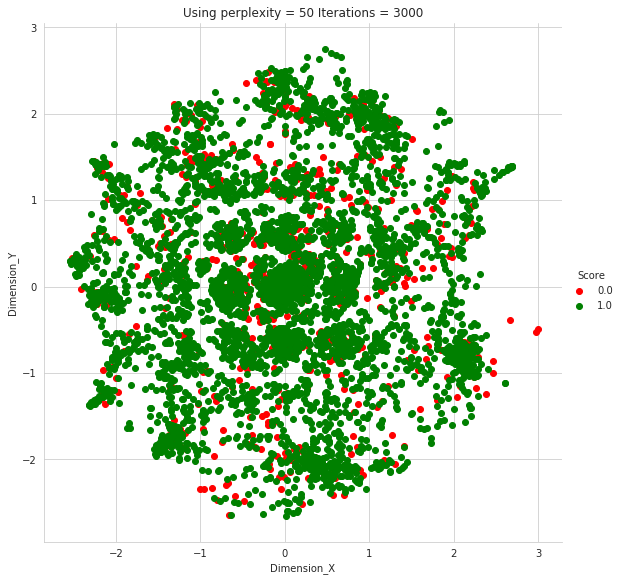

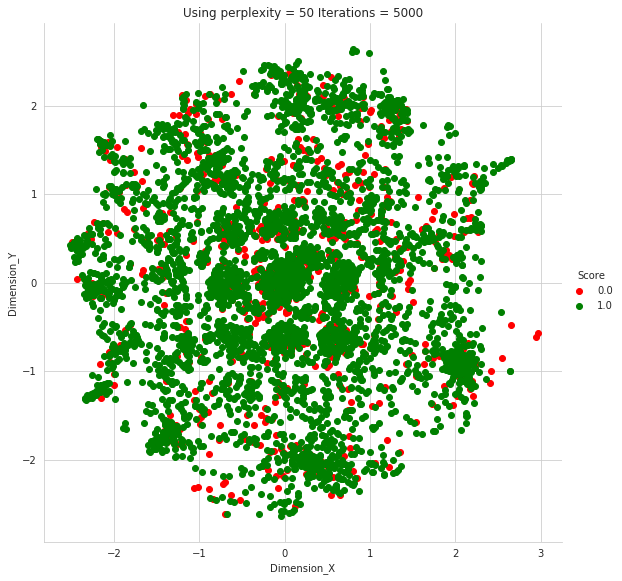

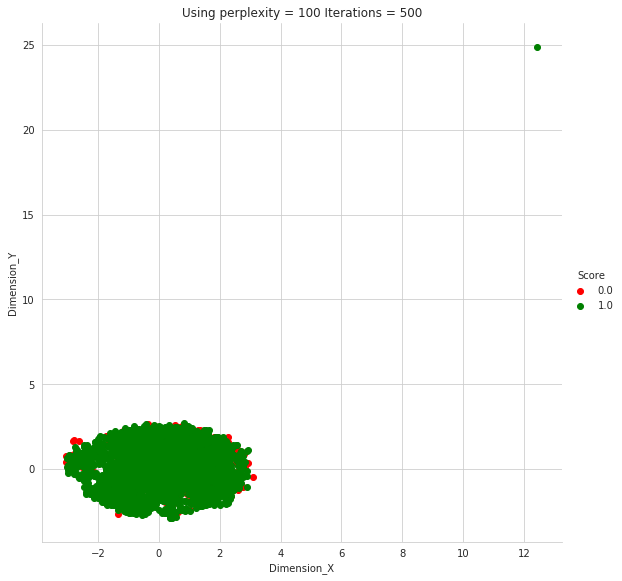

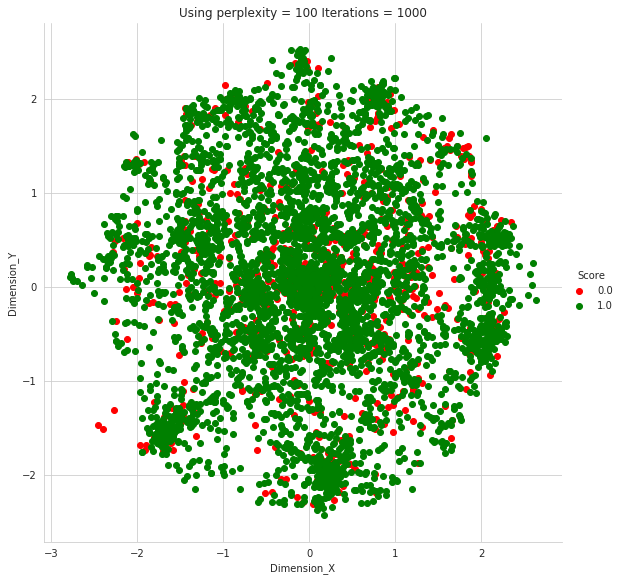

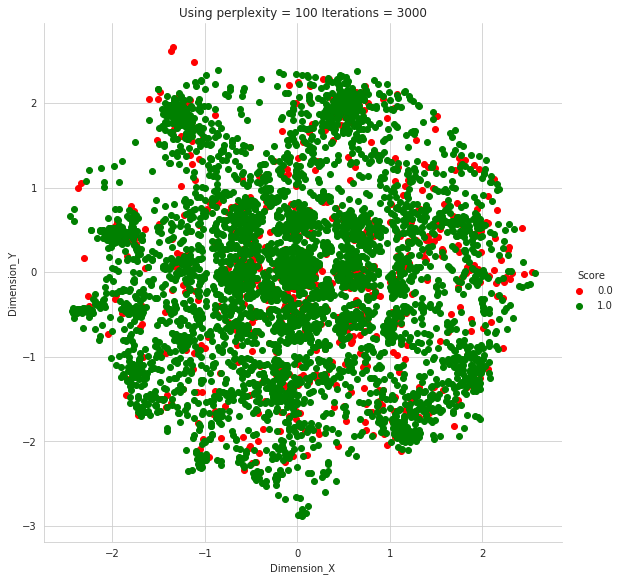

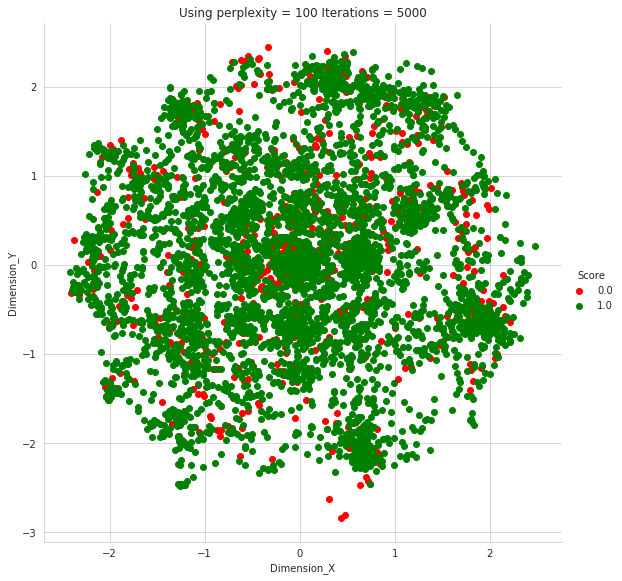

In [ ]:


perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of Tf-IDF vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = final_tf_idf.A, review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

Applying TNSE on Text Avg W2V vectors

2-D representation of W2V vectors using TSNE


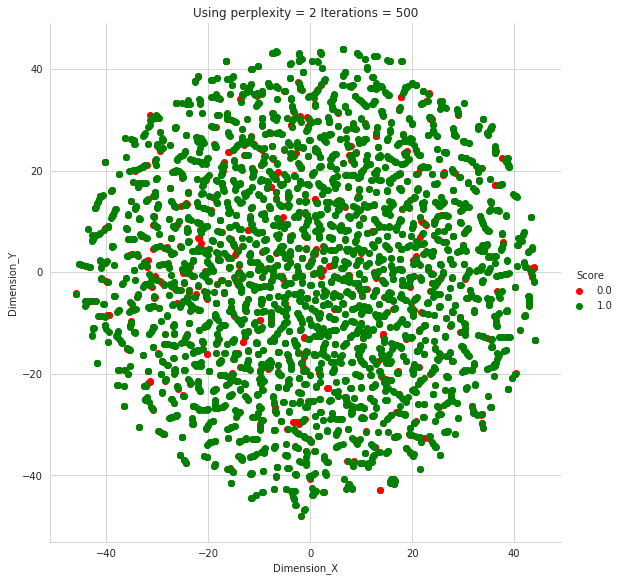

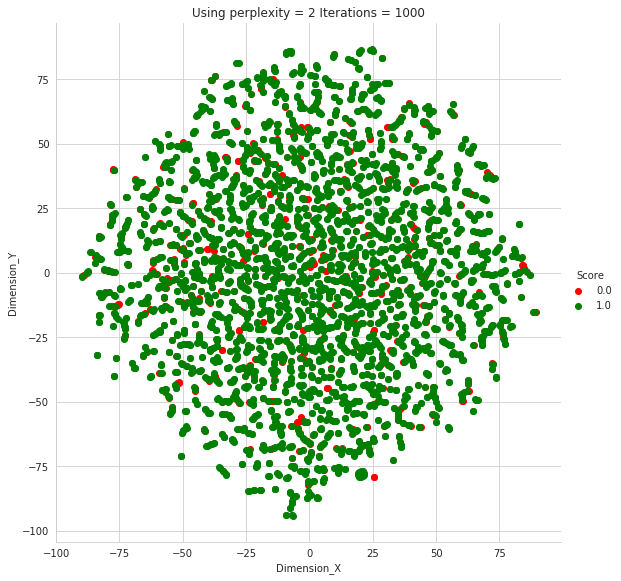

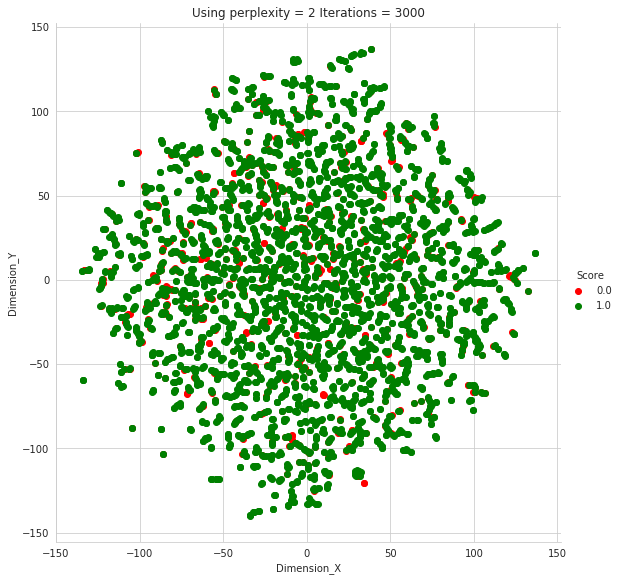

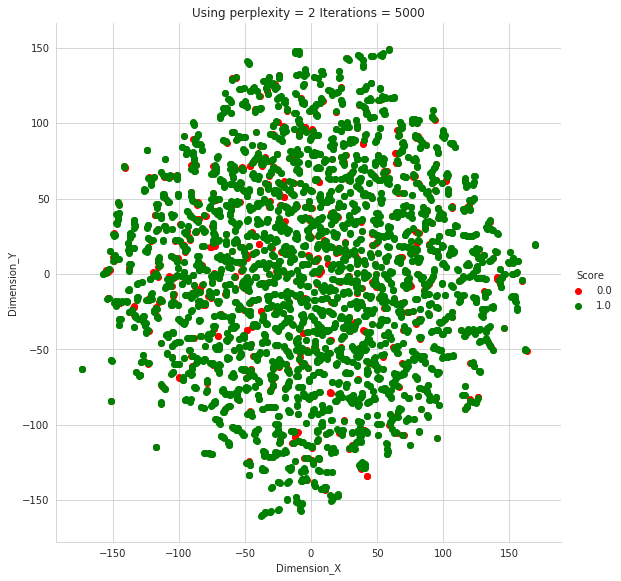

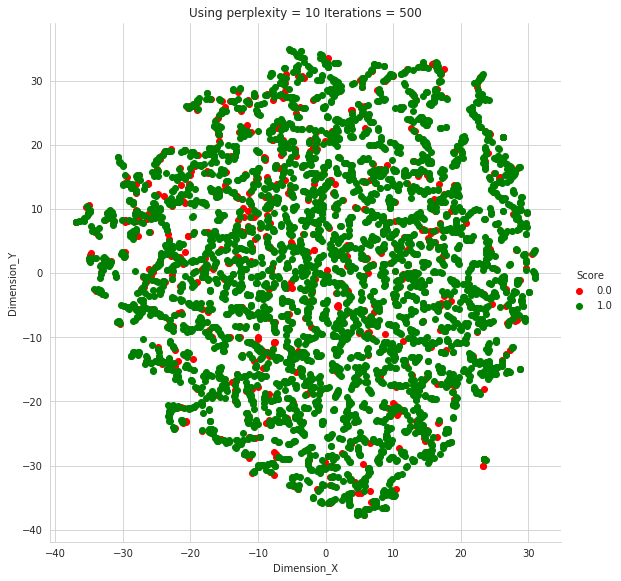

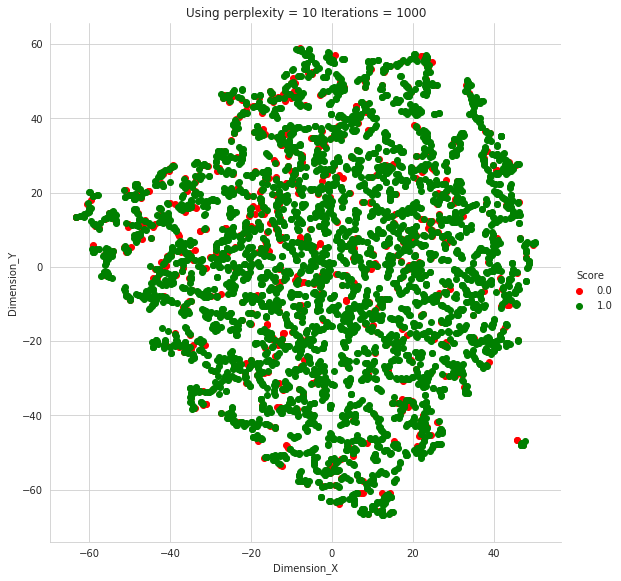

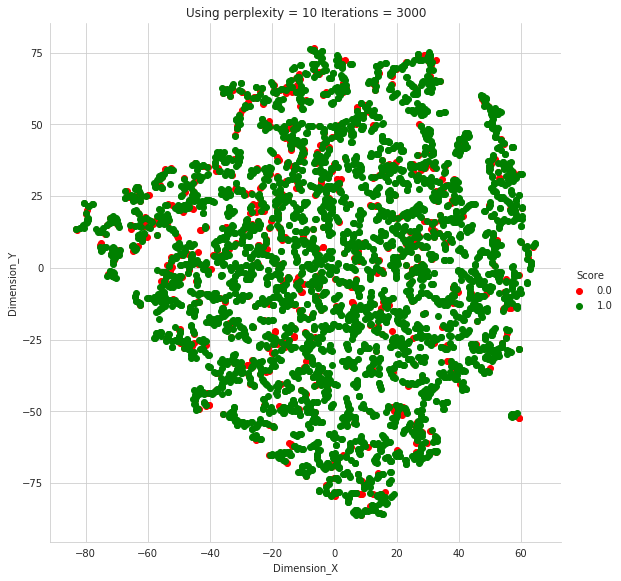

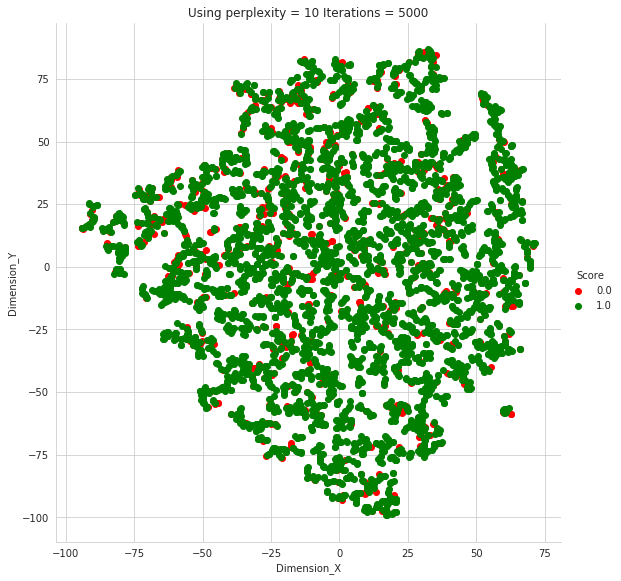

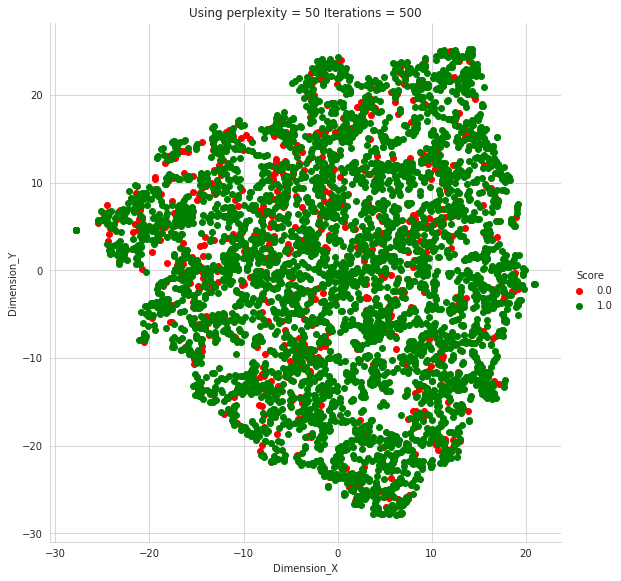

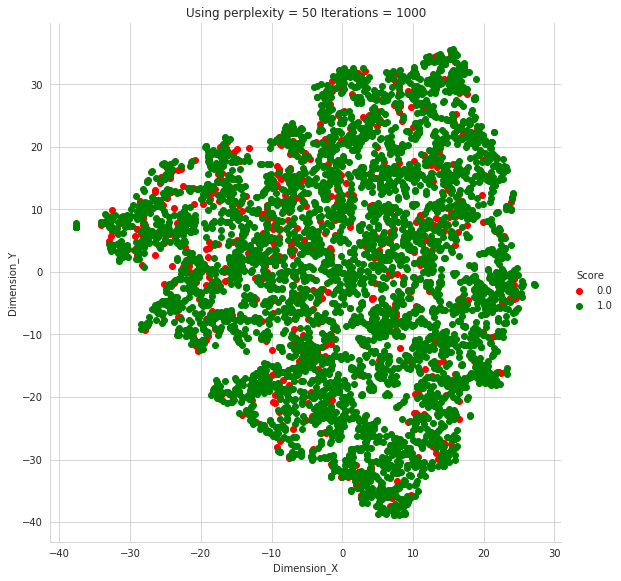

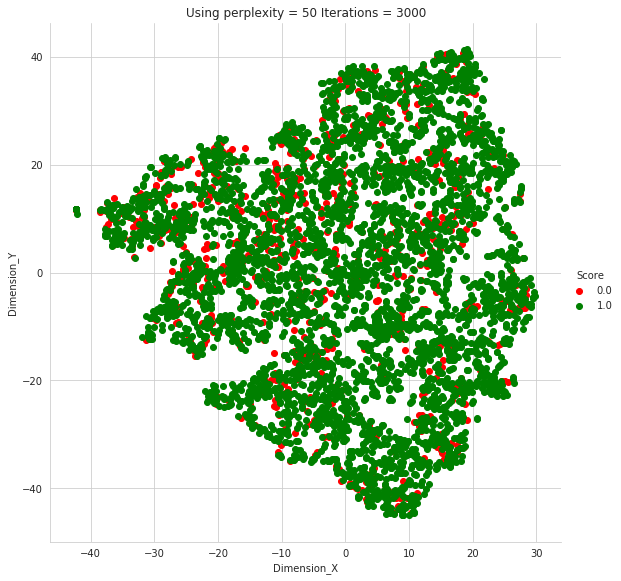

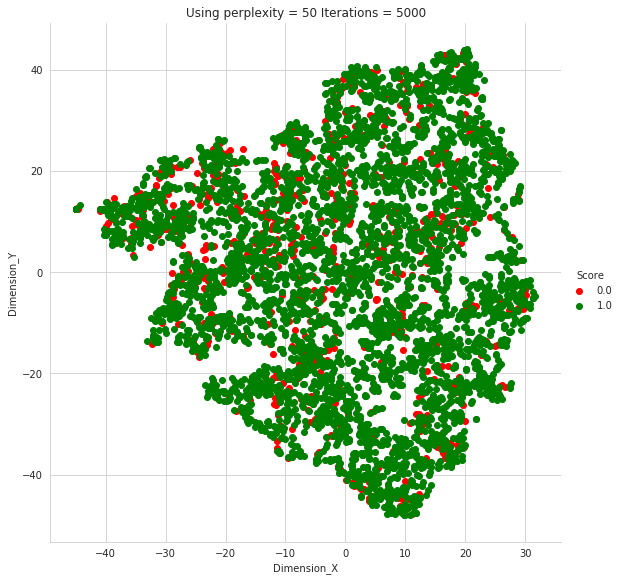

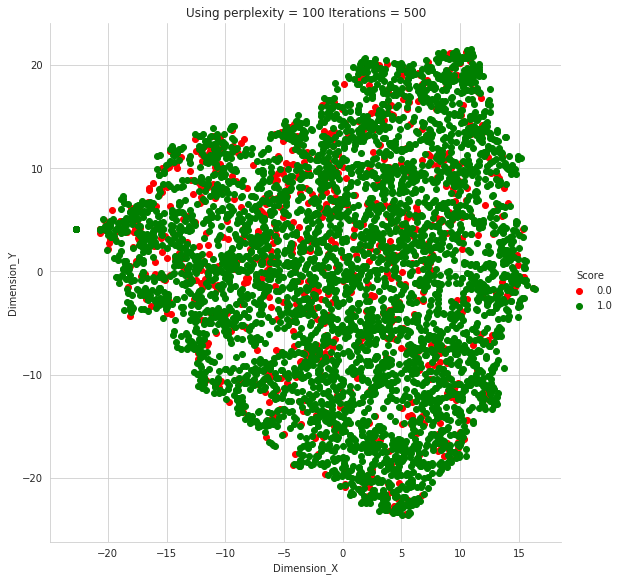

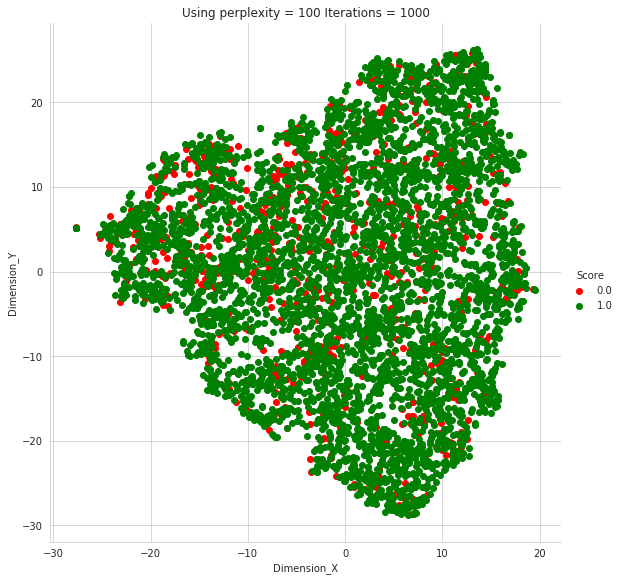

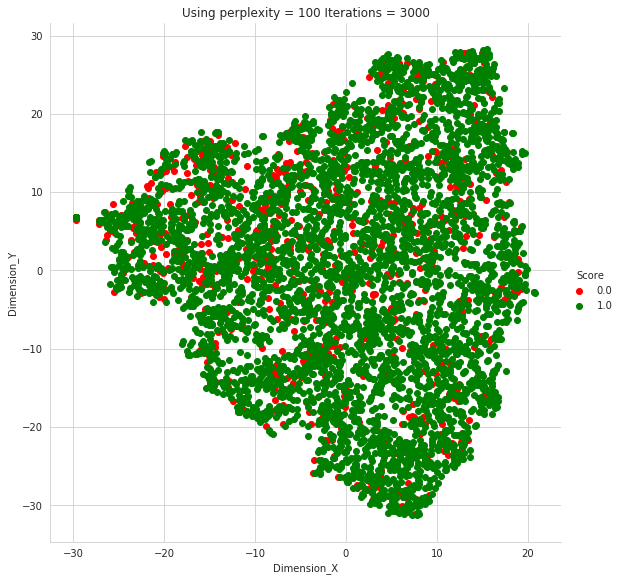

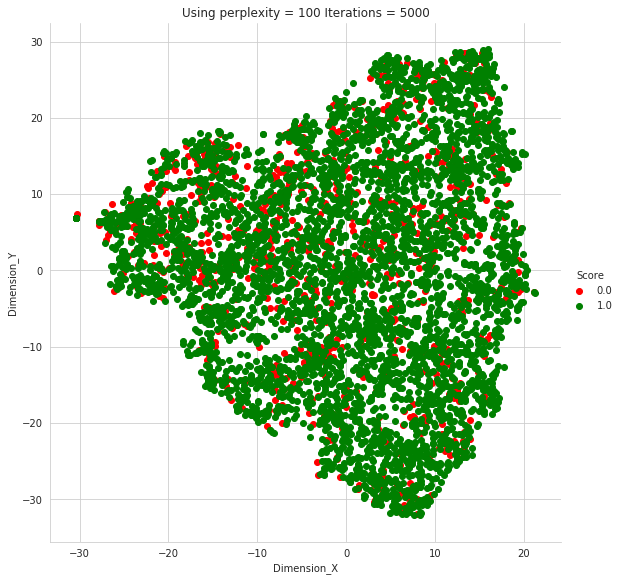

In [ ]:


perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of W2V vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the count vectors to sparse matrix form
        x, y = np.array(sent_vectors), review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

Applying TNSE on Text TFIDF weighted W2V vectors

2-D representation of Tf-IDF weighted W2V vectors using TSNE


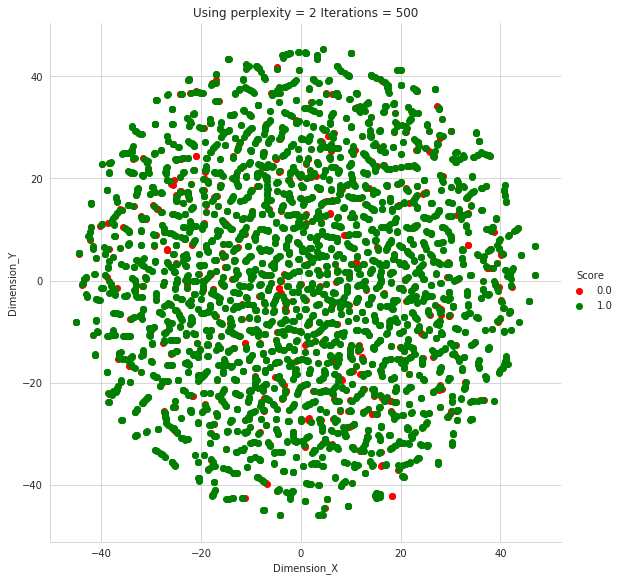

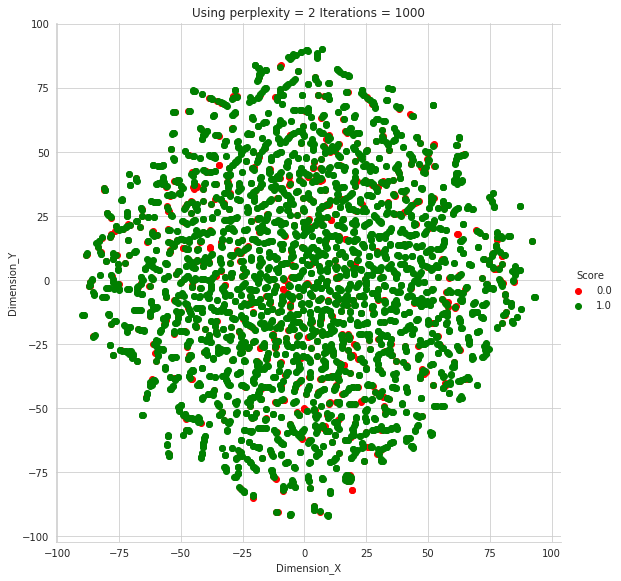

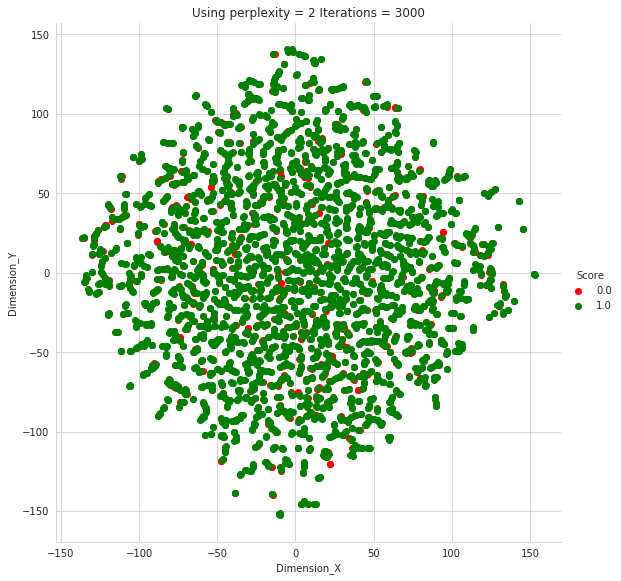

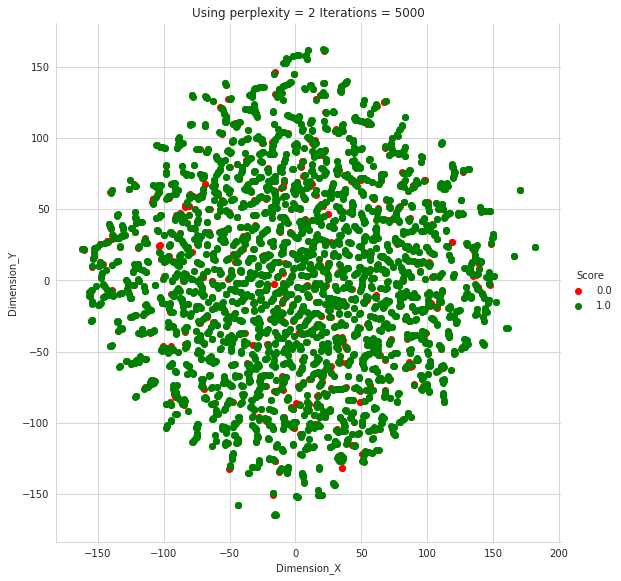

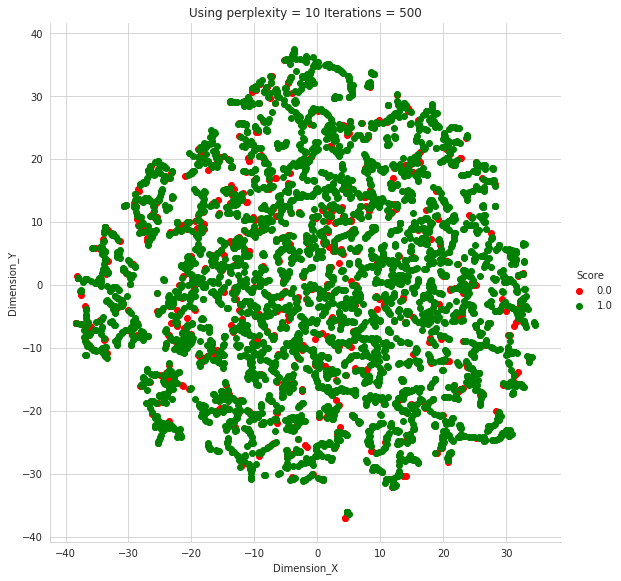

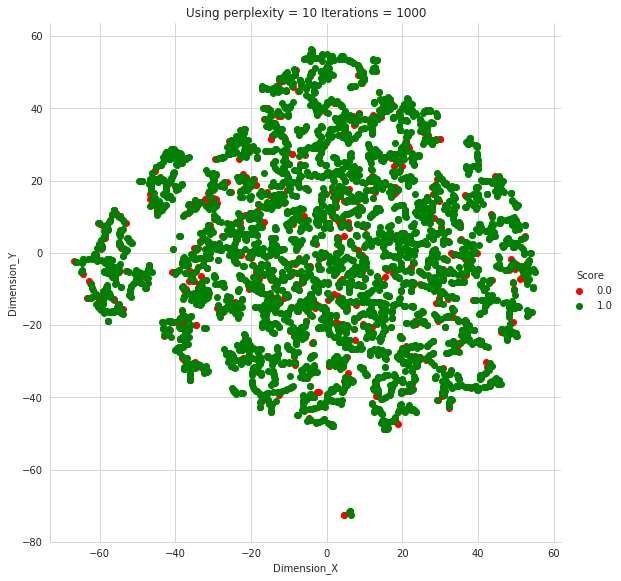

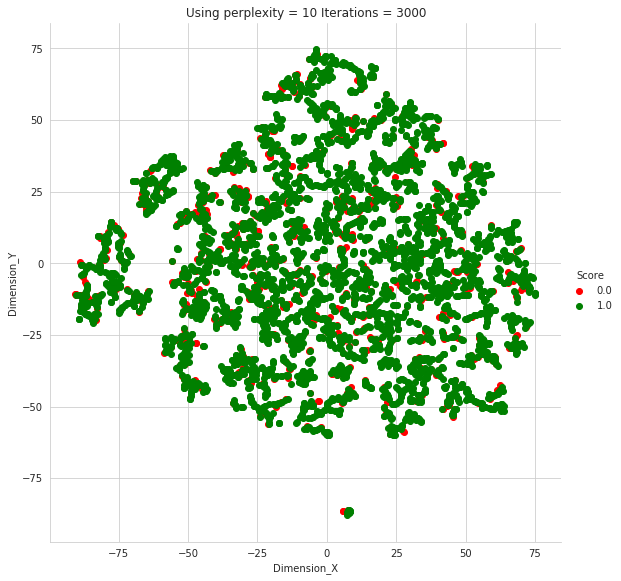

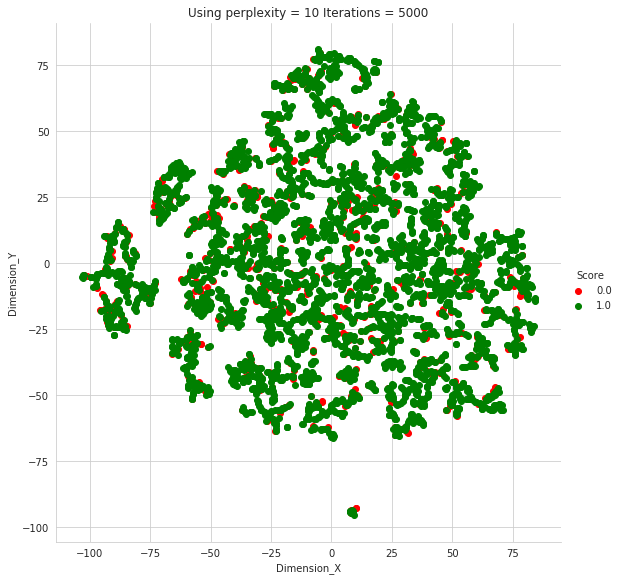

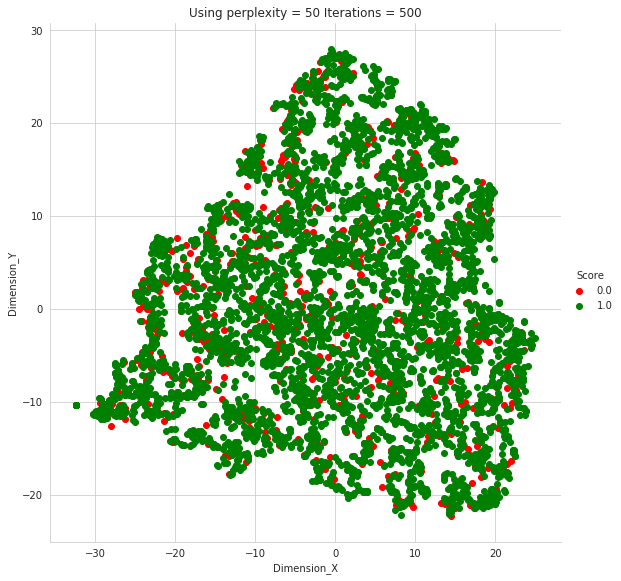

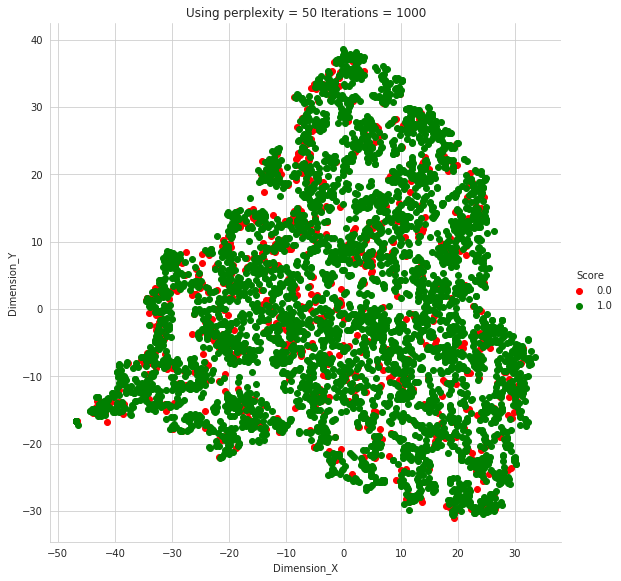

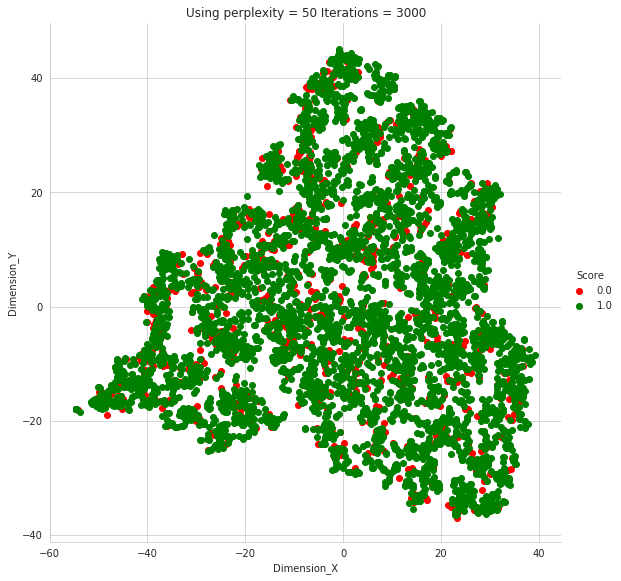

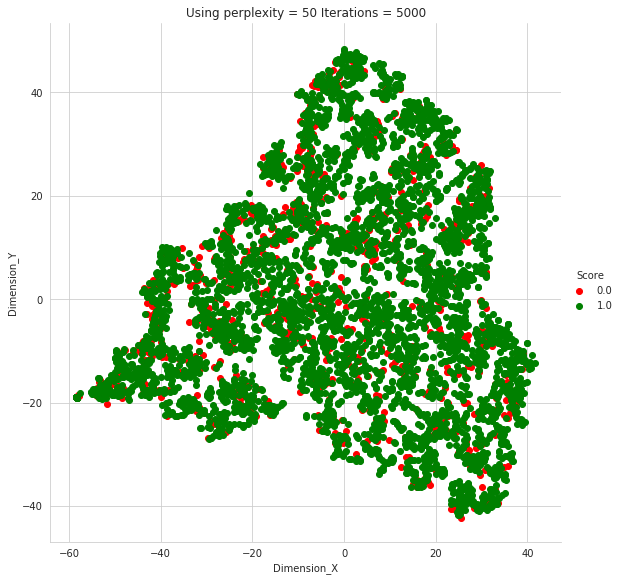

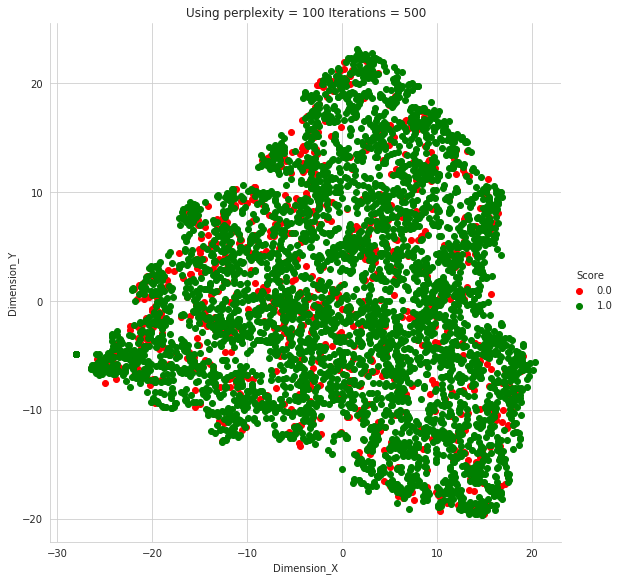

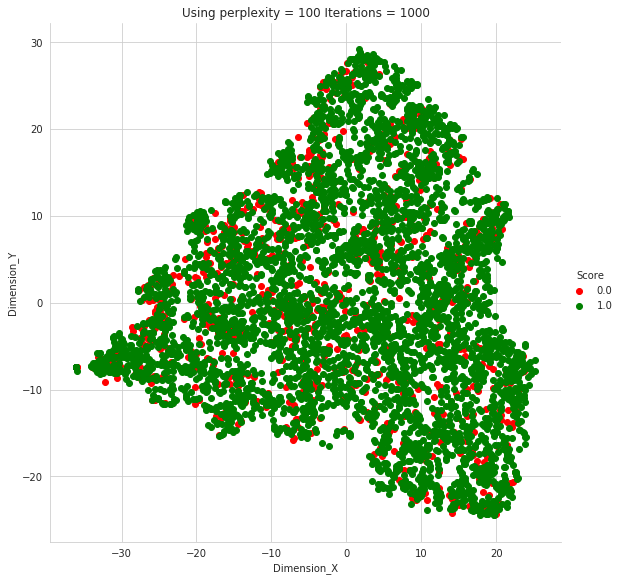

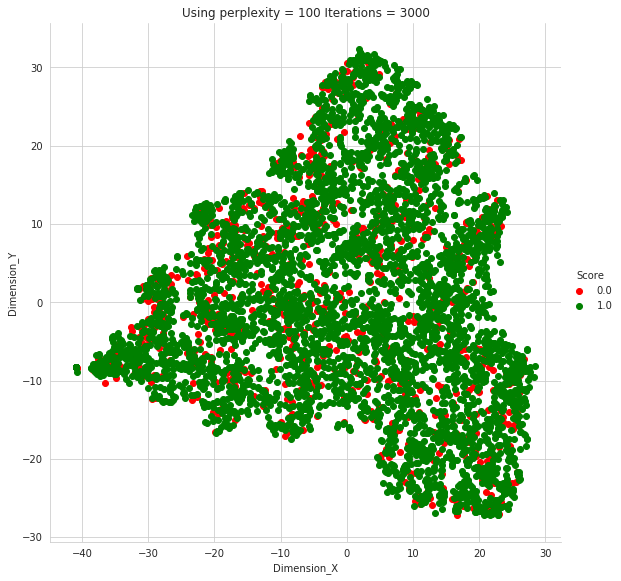

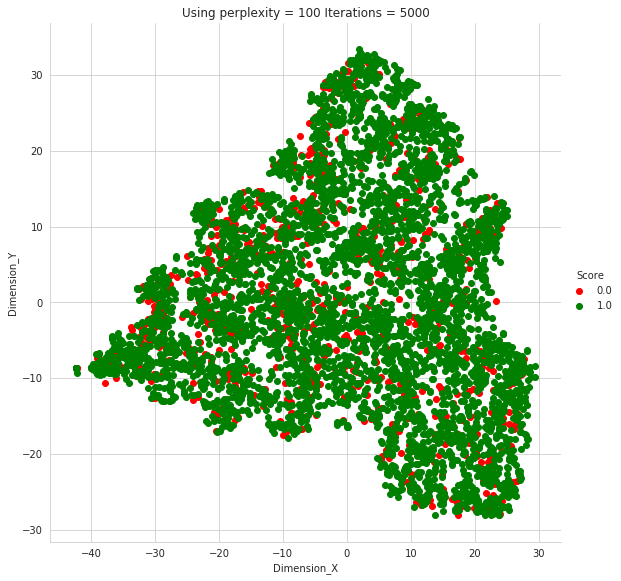

In [ ]:


perplexity_values = [2, 10, 50, 100]
iteration_values = [500, 1000, 3000, 5000]
print('2-D representation of Tf-IDF weighted W2V vectors using TSNE')

for perplexity in perplexity_values:
    for iteration in iteration_values:

        # converting the to matrix form
        x, y = np.array(tfidf_sent_vectors), review_score
        
        # setting up TSNE
        X_embedding = TSNE(n_components=2, random_state=0, perplexity=perplexity,
                           n_iter=iteration, n_jobs=4).fit_transform(x) 
        
        # creating a new data fram which help us in ploting the result data
        tsne_data = np.vstack((X_embedding.T, y)).T
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

        sns.set_style("whitegrid");
        sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
           .map(plt.scatter, "Dimension_X", "Dimension_Y") \
           .add_legend();
        plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
        plt.show(); 

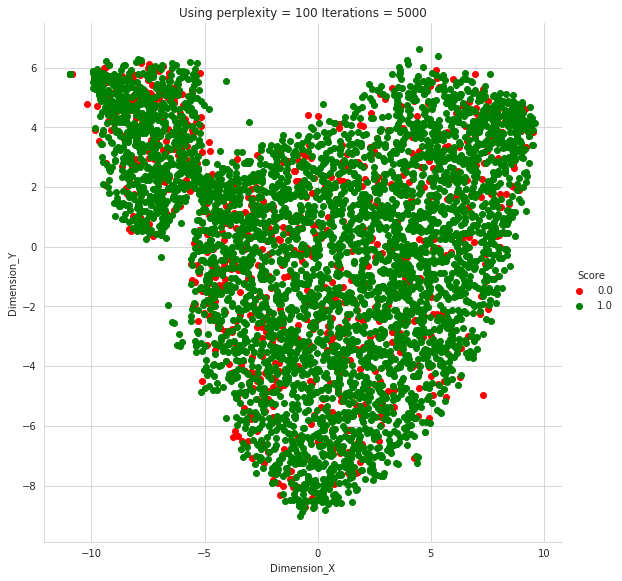

In [ ]:
# trying Tf_IDF weighted W2V with perplexity = 800 on high value of iterations
x, y = np.array(tfidf_sent_vectors), review_score

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=800,
                   n_iter=5000, n_jobs=4).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
   .map(plt.scatter, "Dimension_X", "Dimension_Y") \
   .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

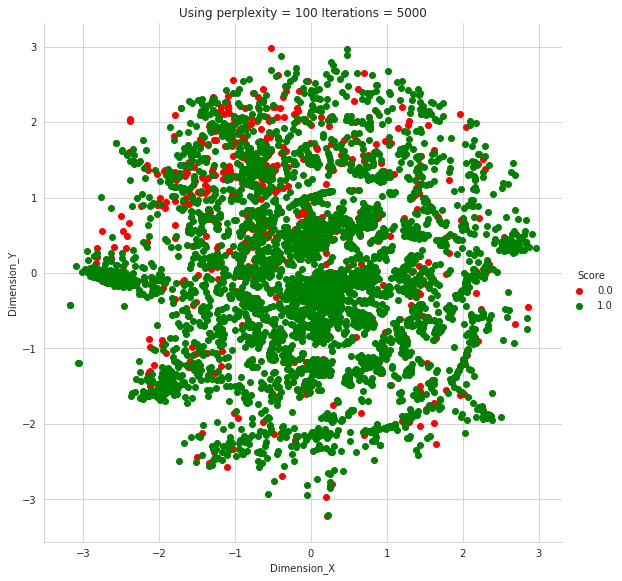

In [ ]:
# trying on bigrams with perplexity = 500 on high value of iterations
x, y = final_bigram_counts.A, review_score

# setting up TSNE
X_embedding = TSNE(n_components=2, random_state=0, perplexity=500,
                   n_iter=5000, n_jobs=4).fit_transform(x) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((X_embedding.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension_X", "Dimension_Y", "Score"))

sns.set_style("whitegrid");
sns.FacetGrid(tsne_df, hue="Score", height=8, palette=["r", "g"]) \
   .map(plt.scatter, "Dimension_X", "Dimension_Y") \
   .add_legend();
plt.title('Using perplexity = {} Iterations = {}'.format(perplexity, iteration))
plt.show(); 

Conclusions

In [ ]:
* For the BOW vectorization we do not get a good representation of data as it is a simple count based technique. Although we see some grouping shows up in this but that is only for small value of perplexity (neighbourhood). There is no consideration of meanings or symantic similarity in BOW

* The Tf-IDF representation proves to be much better as compared to the BOW representation as it tries to focus on the unique words from the corpus rather than simple count based scoring. On smaller values of perlexity it is successfully able to single out the negative reviews

* As for the average word2Vec representation, theoretically it should beat the above two representations with ease but in almost all the observations we see the positive reviews scattered uniformly with the negative reviews dotting the plot in random positions. Although for large values of perplexity and iterations we see a shift in the position of negative reviews to upper region of the plot.

* As for the Tf-IDF weighted word2Vec representation we do not see any significant improvement from the average word2Vec.

**We know the word2Vec to be one of the best representations, but we do not see it helping to demarcate the positive and negative reviews very prominently, in this experiment. One reason we can point out for this is that possibly 50 dims is far too less to catch the entire information, and applying TSNE after that further cause info loss. We are unable to increase dimensions due to hardware constraints.**

* We even tries TSNE on bigrams as test. It was successfully able to create a cluster of very small groups throughout the plot, while the negative reviews were focussed mainly on the top region of the plot. 
